## Imports de bibliothèques python

In [1]:
# Imports
import os
working_dir = os.getcwd()

import h5py

# Personal toolboxes
import sys
sys.path.insert(1, './/..//toolboxes')

from utils_plot import * 
from utils_SHanalysis import *
from utils_geometry import * 
from utils_acoustics import *
from theory_spherical_cap import *

import numpy as np


# Plots 
import matplotlib.pyplot as plt

%matplotlib widget

## Théorie

In [6]:
r_baffle = 8.5e-2
r_opening = 3.5e-2
theta_0 = np.arctan(r_opening/r_baffle)
rho0 = 1.293

freqvect = np.arange(1000, 3050, 50) # Hz
N_freq = len(freqvect)
c0 = 343 # m/s
kvect = 2*np.pi*freqvect/c0 

nbtheta_look = 51
nbphi_look = 103
angles_look = create_equal_angle_grid(nbtheta_look, nbphi_look)

N_SH_max = 6

# compute axis-symetrical SH coefficients of the pressure at origin
SHcoefs_velocity_on_baffle = -1j*rho0*c0*comp_SHcoefs_velocity_on_baffle_piston_sphericalbaffle(kvect, r_sphere = r_baffle, r_opening = r_opening, N_SH_max = N_SH_max, Wdot = 1)
SH_orders = np.arange(N_SH_max+1, dtype = int)
SHcoefs_pressure = SHcoefs_velocity_on_baffle[:,np.newaxis]/spherical_hn_diff(SH_orders[:,np.newaxis],kvect[np.newaxis,:]*r_baffle) # SH coefs of the pressure at the origin (cmn)

# transform axis-symmetrical SH coefficients into classical SH ones
SHcoefs_th = np.zeros(((N_SH_max+1)**2, N_freq), dtype = complex)
for ind_SH in range(N_SH_max):
    alpha_n = np.sqrt(4*np.pi/(2*ind_SH+1))
    SHcoefs_th[ind_SH**2 + ind_SH,:] = SHcoefs_pressure[ind_SH,:]*alpha_n # Y_{nm}(\theta, \phi)

## Position des micros

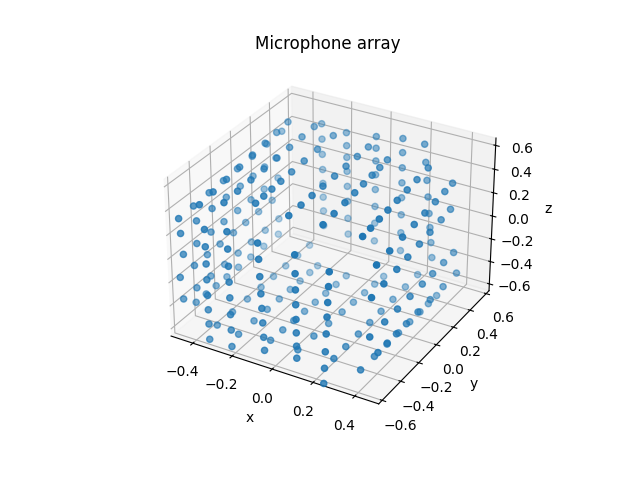

In [3]:
array_file = 'exp_data/calib_geo/XYZm_Calib3_aligne.npz' #working_dir + '//../calib_geo/XYZm_Calib3_aligne.npz'
XYZ = np.load(array_file)['XYZm'][:-1,:] 

rot_angle = np.pi/2
Ry = np.array([[np.cos(rot_angle),0,np.sin(rot_angle)],[0,1,0],[-np.sin(rot_angle),0,np.cos(rot_angle)]])


#00cm
center_source = [-7.5e-2,0,15e-2]
# center_source = [-11.5e-2,0,16e-2]

'''
#10cm
center_source = [-7.5e-2,0,25e-2]
'''

'''
#26cm
center_source = [-7.5e-2,0,41e-2]
'''

ind_samples = [27*8, 12*8, 0, 31*8 + 7, 28*8, 20*8+2 , 2*8, 1*8, 12*8 + 7, 29*8+4, 24*8+3]
XYZ_samples_ref = np.array([[50,30,53], 
                    [-67,-39, -21],
                    [-49, 54, 45],
                    [28,-50,-29],
                    [24, -61, 42],
                    [0,-60,-13],
                    [50,25,-22],
                    [-65,-41,53],
                    [-66,40,-5],
                    [-23,0,-29],
                    [-4,-4,60]], dtype = float)*1e-2

XYZ_ref_retrieved = XYZ[ind_samples[2],:]
XYZ_ref_real = XYZ_samples_ref[2,:]

XYZ[:,1] *=-1
XYZ_centered  = XYZ - XYZ_ref_retrieved + XYZ_ref_real

XYZ_Mems = XYZ_centered[:-1,:]-center_source
XYZ_Mems = XYZ_Mems@Ry

plot_array(XYZ_Mems)


## Chargement des mesures

In [4]:
r_array = 1.4

eta = 3
N_SH_vect = compute_N_SH_vect(freqvect, N_SH_max, rmin = r_array, eta = eta, c0 = c0) # ordre de troncature dépendant de la fréquence pour la méthode 1


source_folder = './exp_data/DataCalotte_00cm/'
input_file = 'mu5h-20230517-150510.h5'


data = h5py.File(source_folder + input_file,'r') #working_dir + source_folder + input_file, 'r')  
    
Secs = [int(i) for i in data['muh5'].keys()] 
NbSecs = len(data['muh5'].keys())

Sig = np.concatenate([data['muh5'][str(i)]['sig'][:] for i in range(NbSecs)], axis=1)

fs = 50e3
Nsamples = int(NbSecs*fs)
ind_Mems_ref = 4*8+3
vectf = np.fft.rfftfreq(Nsamples, 1/fs)
ind_freq_study = []
for ind_freq in range(len(freqvect)):
    ind_freq_study.append(np.argmin(np.abs(freqvect[ind_freq] - vectf)))
SH_center = np.array([-7.5e-2,0,15e-2])@Ry

Mems = Sig[1:257,:]
Ref = Sig[257:,:]
SRef = np.fft.rfft(Ref, axis = 1)
SMems = np.fft.rfft(Mems)
TF_Memsref_Memsi = SMems/SMems[ind_Mems_ref,:]
x_meas = TF_Memsref_Memsi[:,ind_freq_study]

c:\Users\augus\Desktop\Stage_augustin\notebooks\utils_SHanalysis.py:221: RuntimeWarning: divide by zero encountered in divide
  kr_farfield = eta*(scsp.factorial(2*n_SH_vect)/(2**n_SH_vect*scsp.factorial(n_SH_vect)))**(1/n_SH_vect) # check eqs 7 8 Hartenstein et al FA 2023


In [10]:
lambda_reg = 1e-4

N = 6

x_min = -5
x_max = 6
x_step = 1
z_min = 5
z_max = -6
z_step = -1

x_grid = np.arange(x_min, x_max, x_step)
z_grid = np.arange(z_min, z_max, z_step)

NCC = np.zeros((len(x_grid),len(z_grid)))

for iz,dz in enumerate(z_grid) :
    print(dz)
    for ix,dx in enumerate(x_grid) :
        XYZ_Mems = XYZ_centered[:-1,:]-center_source + [dx*1e-2, 0, dz*1e-2]
        XYZ_Mems = XYZ_Mems@Ry

        H_array = compute_SphericalWavesbasis_origin_to_field(XYZ_Mems, kvect, N)
        cmn = compute_SHcoefs(x_meas, H_array, N_SH_vect = N_SH_vect, lambda_reg=lambda_reg)
        Dinf_meas = compute_Dinf_from_SH_coefs_on_sphere(cmn,angles_look, kvect, r_baffle)


        NCC[ix,iz] = np.mean(compute_NCC(np.abs(cmn), np.abs(SHcoefs_th)))


5
4
3
2
1
0
-1
-2
-3
-4
-5


Text(114.1722222222222, 0.5, 'distance from the original center, z axis (cm)')

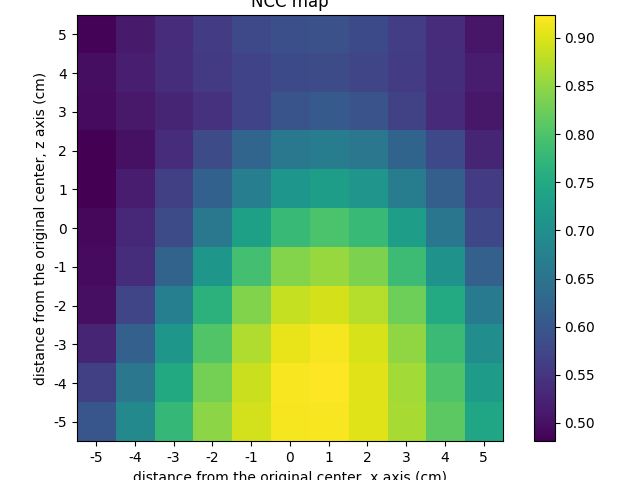

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(NCC)
ax.set_xticks(np.arange(NCC.shape[1]), labels = np.round(np.arange(x_min, x_max, x_step),2))
ax.set_yticks(np.arange(NCC.shape[0]), labels = np.round(np.arange(z_min, z_max, z_step),2))

fig.tight_layout()
fig.colorbar(im)
plt.title(f'NCC map')
plt.xlabel('distance from the original center, x axis (cm)')
plt.ylabel('distance from the original center, z axis (cm)')